In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.model_selection import train_test_split

import sys
sys.path.append("/Users/lsp/Documents/projets/en_cours/eeg/eeg")
from eeg import create3DMatrix, loadEEG, getEvents, getTrialNumList, plotFFTElectrodes, plot3DMatrix, computePickEnergy, plotFFT, preparePlotFFT

sys.path.append("/Users/lsp/Documents/projets/en_cours/eeg/dss")
from dss import crossValidateDSS, createBiasedSignal, covUnnorm, computeDSS, applyDSS

from tools.eeg_utils import processEEG, loadDataH5
from tools.audio import getAttendedAndUnattendedEnv, butterLpass
from tools.behavior import getBehaviorData, analyses, checkLinkTrialsBehaviorEEG
from tools.decodingTRF import getTRFAccuracyByDur, getUnattendedTrialsNumber, calculateCorr
from tools.decodingSSR import calculateBaseline, comparePicks, getSSRAccuracyByDur, crossVal, hyperOptC, getBestAcc


In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%matplotlib notebook

In [6]:
# Plot parameters
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'

%pylab inline
pylab.rcParams['figure.figsize'] = (18, 10)

Populating the interactive namespace from numpy and matplotlib


# Analyses aSSR

In [7]:
# [-1] because we need only data for aSSR analysis now
eeg_aSSR_p1 = loadDataH5('data_preproc/data_p1.h5',
                        'data_preproc/reconstructed_p1.h5')[-1]
eeg_aSSR_p2 = loadDataH5('data_preproc/data_p2.h5',
                        'data_preproc/reconstructed_p2.h5')[-1]
eeg_aSSR_p3 = loadDataH5('data_preproc/data_p3.h5',
                        'data_preproc/reconstructed_p3.h5')[-1]
eeg_aSSR_p4 = loadDataH5('data_preproc/data_p4.h5',
                        'data_preproc/reconstructed_p4.h5')[-1]


In [8]:
eeg_aSSR_all = np.concatenate([eeg_aSSR_p1, eeg_aSSR_p2, eeg_aSSR_p3, eeg_aSSR_p4])
del eeg_aSSR_p1, eeg_aSSR_p2, eeg_aSSR_p3, eeg_aSSR_p4

In [9]:
# Get behavior data
trialBehavior_p1 = getBehaviorData(dbName='hijee_18_06', sessionNums=np.arange(1, 9))
trialBehavior_p2 = getBehaviorData(dbName='thomas_20_06', sessionNums=np.arange(1, 9))
trialBehavior_p3 = getBehaviorData(dbName='isaac_21_06', sessionNums=np.arange(1, 9))
trialBehavior_p4 = getBehaviorData(dbName='thomas_22_06', sessionNums=np.arange(1, 9))

loading session 1
loading session 2
loading session 3
loading session 4
loading session 5
loading session 6
loading session 7
loading session 8
loading session 1
loading session 2
loading session 3
loading session 4
loading session 5
loading session 6
loading session 7
loading session 8
loading session 1
loading session 2
loading session 3
loading session 4
loading session 5
loading session 6
loading session 7
loading session 8
loading session 1
loading session 2
loading session 3
loading session 4
loading session 5
loading session 6
loading session 7
loading session 8


In [10]:
subjs = [trialBehavior_p1, trialBehavior_p2, trialBehavior_p3, trialBehavior_p4]
allBadTrials = []
for i in range(len(subjs)):
    performances = analyses(subjs[i], verbose=False)
    allBadTrials.append(performances.trial[performances.dprime<0.5].values + (80*i))

allBadTrials = np.concatenate(allBadTrials)

In [12]:
trialsSession1 = np.concatenate([np.arange(10), np.arange(10)+(80), np.arange(10)+(80*2),
                                np.arange(10)+(80*3)])
trialsSession2 = np.concatenate([np.arange(10, 20), np.arange(10, 20)+(80),
                                 np.arange(10, 20)+(80*2),
                                np.arange(10, 20)+(80*3)])
trialsSession3 = np.concatenate([np.arange(20, 30), np.arange(20, 30)+(80),
                                 np.arange(20, 30)+(80*2),
                                np.arange(20, 30)+(80*3)])
trialsSession4 = np.concatenate([np.arange(30, 40), np.arange(30, 40)+(80),
                                 np.arange(30, 40)+(80*2),
                                np.arange(30, 40)+(80*3)])
trialsSession5_6 = np.concatenate([np.arange(40, 60), np.arange(40, 60)+(80),
                                 np.arange(40, 60)+(80*2),
                                np.arange(40, 60)+(80*3)])
trialsSession7_8 = np.concatenate([np.arange(60, 80), np.arange(60, 80)+(80),
                                 np.arange(60, 80)+(80*2),
                                np.arange(60, 80)+(80*3)])

trialsSession1Good = np.setdiff1d(trialsSession1, allBadTrials.astype(int))
trialsSession2Good = np.setdiff1d(trialsSession2, allBadTrials.astype(int))
trialsSession3Good = np.setdiff1d(trialsSession3, allBadTrials.astype(int))
trialsSession4Good = np.setdiff1d(trialsSession4, allBadTrials.astype(int))
trialsSession5_6Good = np.setdiff1d(trialsSession5_6, allBadTrials.astype(int))
trialsSession7_8Good = np.setdiff1d(trialsSession7_8, allBadTrials.astype(int))

a (29696, 1)
0
a (29696, 1)
0
a (29696, 1)
0
a (29696, 1)
0
a (29696, 1)
0
a (29696, 1)
0


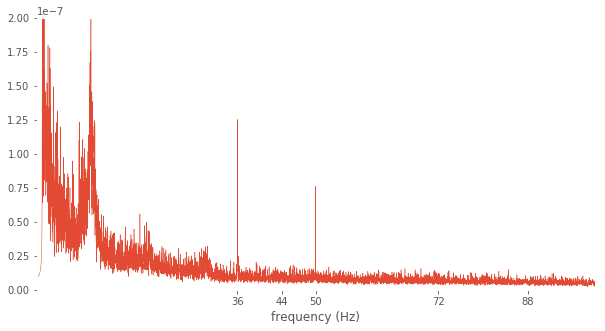

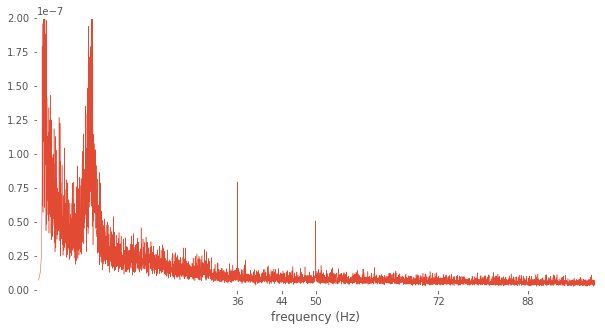

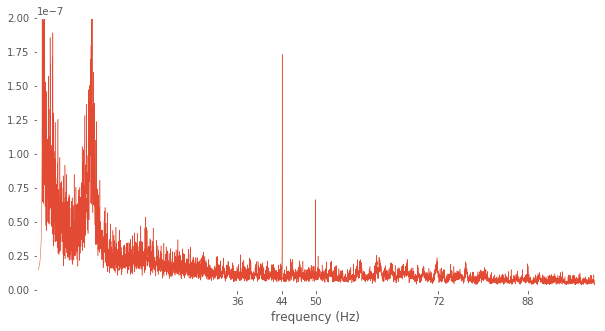

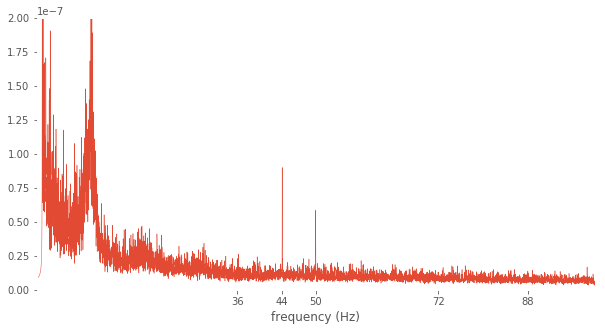

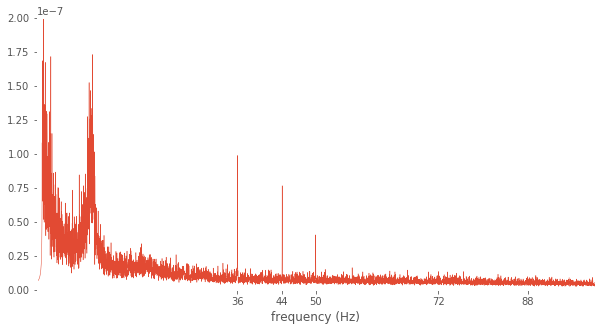

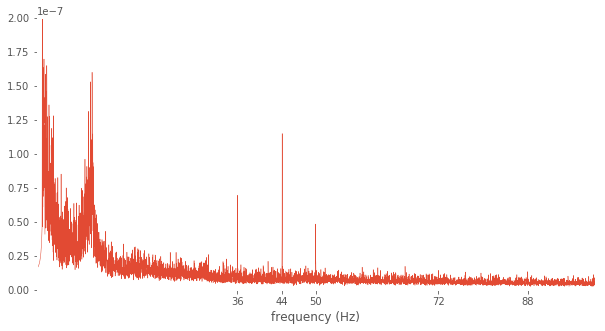

In [13]:
pylab.rcParams['figure.figsize'] = (10, 5)
fftSess1 = plot3DMatrix(eeg_aSSR_all,
             picks=np.arange(64),
             trialList=trialsSession1,
             average=True,
             trialDur=60,
             offset=0,
             normalize=False,
             fs=512.,
             freqMin=0,
             freqMax=100,
             yMin=0,
             yMax=0.0000002,
             xticks=[36, 44, 50, 72, 88],
             averageTimeDomain=True,
            averageElectrodes=True,
            returnFFT=True)
fftSess2 = plot3DMatrix(eeg_aSSR_all,
             picks=np.arange(64),
             trialList=trialsSession2,
             average=True,
             trialDur=60,
             offset=0,
             normalize=False,
             fs=512.,
             freqMin=0,
             freqMax=100,
             yMin=0,
             yMax=0.0000002,
             xticks=[36, 44, 50, 72, 88],
             averageTimeDomain=True,
            averageElectrodes=True,
            returnFFT=True)
fftSess3 = plot3DMatrix(eeg_aSSR_all,
             picks=np.arange(64),
             trialList=trialsSession3,
             average=True,
             trialDur=60,
             offset=0,
             normalize=False,
             fs=512.,
             freqMin=0,
             freqMax=100,
             yMin=0,
             yMax=0.0000002,
             xticks=[36, 44, 50, 72, 88],
             averageTimeDomain=True,
            averageElectrodes=True,
            returnFFT=True)
fftSess4 = plot3DMatrix(eeg_aSSR_all,
             picks=np.arange(64),
             trialList=trialsSession4,
             average=True,
             trialDur=60,
             offset=0,
             normalize=False,
             fs=512.,
             freqMin=0,
             freqMax=100,
             yMin=0,
             yMax=0.0000002,
             xticks=[36, 44, 50, 72, 88],
             averageTimeDomain=True,
            averageElectrodes=True,
            returnFFT=True)
fftSess5_6 = plot3DMatrix(eeg_aSSR_all,
             picks=np.arange(64),
             trialList=trialsSession5_6,
             average=True,
             trialDur=60,
             offset=0,
             normalize=False,
             fs=512.,
             freqMin=0,
             freqMax=100,
             yMin=0,
             yMax=0.0000002,
             xticks=[36, 44, 50, 72, 88],
             averageTimeDomain=True,
            averageElectrodes=True,
            returnFFT=True)
fftSess7_8 = plot3DMatrix(eeg_aSSR_all,
             picks=np.arange(64),
             trialList=trialsSession7_8,
             average=True,
             trialDur=60,
             offset=0,
             normalize=False,
             fs=512.,
             freqMin=0,
             freqMax=100,
             yMin=0,
             yMax=0.0000002,
             xticks=[36, 44, 50, 72, 88],
             averageTimeDomain=True,
            averageElectrodes=True,
            returnFFT=True)

a (29696, 1)
0


,0
0,0.000210
1,0.000210
2,0.000211
3,0.000211
4,0.000211
5,0.000212
6,0.000212
7,0.000213
8,0.000214
9,0.000214


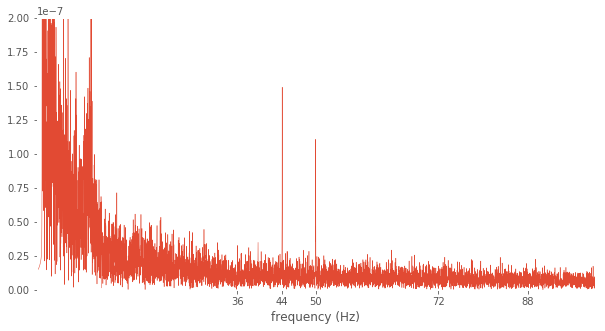

In [14]:
plot3DMatrix(eeg_aSSR_all,
             picks=np.arange(1),
             trialList=trialsSession4,
             average=True,
             trialDur=60,
             offset=0,
             normalize=False,
             fs=512.,
             freqMin=0,
             freqMax=100,
             yMin=0,
             yMax=0.0000002,
             xticks=[36, 44, 50, 72, 88],
             averageTimeDomain=True,
            averageElectrodes=True,
            returnFFT=True)

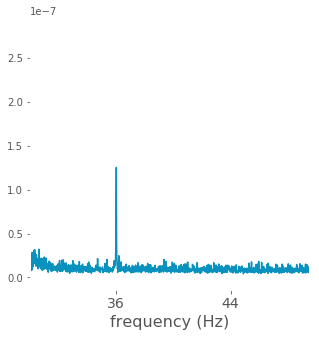

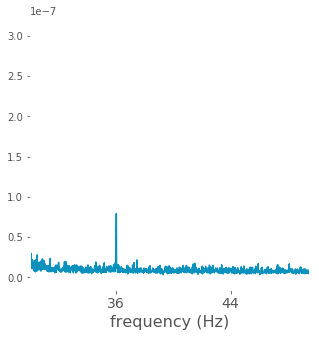

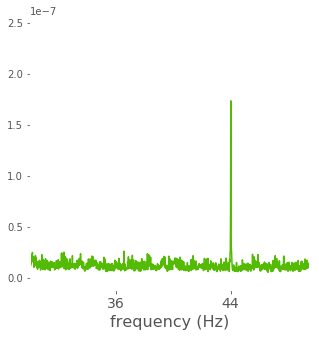

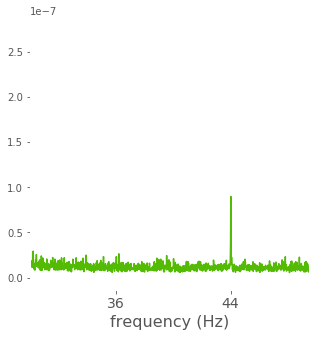

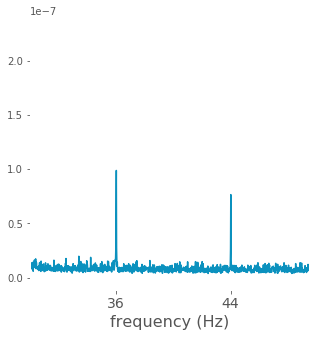

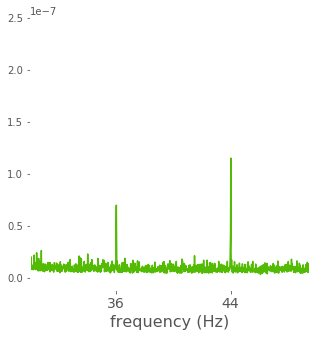

In [15]:
pylab.rcParams['figure.figsize'] = (5, 5)

dataFFT36 = preparePlotFFT(fftSess1, fs=512.)
dataFFT44 = preparePlotFFT(fftSess3, fs=512.)
dataFFT36TC = preparePlotFFT(fftSess2, fs=512.)
dataFFT44TC = preparePlotFFT(fftSess4, fs=512.)
dataFFTAtt36 = preparePlotFFT(fftSess5_6, fs=512.)
dataFFTAtt44 = preparePlotFFT(fftSess7_8, fs=512.)

flatui = ["#0B91BE"]
sns.set_palette(flatui)

diff36 = plt.figure()
plt.plot(dataFFT36)
plt.xlim(30, 49.5)
plt.xticks([36, 44])
plt.xlabel('frequency (Hz)', fontsize=16)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.show()

diff36TC = plt.figure()
plt.plot(dataFFT36TC)
plt.xlim(30, 49.5)
plt.xticks([36, 44])
plt.xlabel('frequency (Hz)', fontsize=16)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.show()

flatui = ["#53BB04"]
sns.set_palette(flatui)

diff44 = plt.figure()
plt.plot(dataFFT44)
plt.xlim(30, 49.5)
plt.xticks([36, 44])
plt.xlabel('frequency (Hz)', fontsize=16)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.show()

diff44TC = plt.figure()
plt.plot(dataFFT44TC)
plt.xlim(30, 49.5)
plt.xticks([36, 44])
plt.xlabel('frequency (Hz)', fontsize=16)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.show()

flatui = ["#0B91BE"]
sns.set_palette(flatui)

att36 = plt.figure()
plt.plot(dataFFTAtt36)
plt.xlim(30, 49.5)
plt.xticks([36, 44])
plt.xlabel('frequency (Hz)', fontsize=16)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.show()

flatui = ["#53BB04"]
sns.set_palette(flatui)

att44 = plt.figure()
plt.plot(dataFFTAtt44)
plt.xlim(30, 49.5)
plt.xticks([36, 44])
plt.xlabel('frequency (Hz)', fontsize=16)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.show()

diff36.savefig("images/diff36.pdf")
diff44.savefig("images/diff44.pdf")
diff36TC.savefig("images/diff36TC.pdf")
diff44TC.savefig("images/diff44TC.pdf")
att36.savefig("images/att36.pdf")
att44.savefig("images/att44.pdf")

In [16]:
dataFFTAtt = preparePlotFFT(fftSess5_6, fs=512.)
dataFFTUnatt = preparePlotFFT(fftSess7_8, fs=512.)

# TC effect on picks

0 [31 37 40 62 64 67 69 70]
1 [19 38 68 75]
2 [30 31 32 36 37 38 44 50 55 59 64 75 77]
3 [33 34 60]


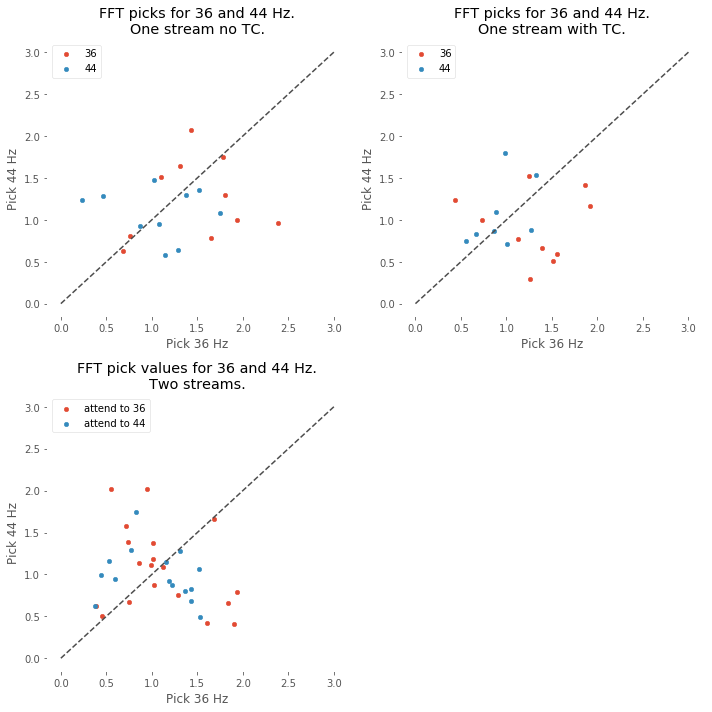

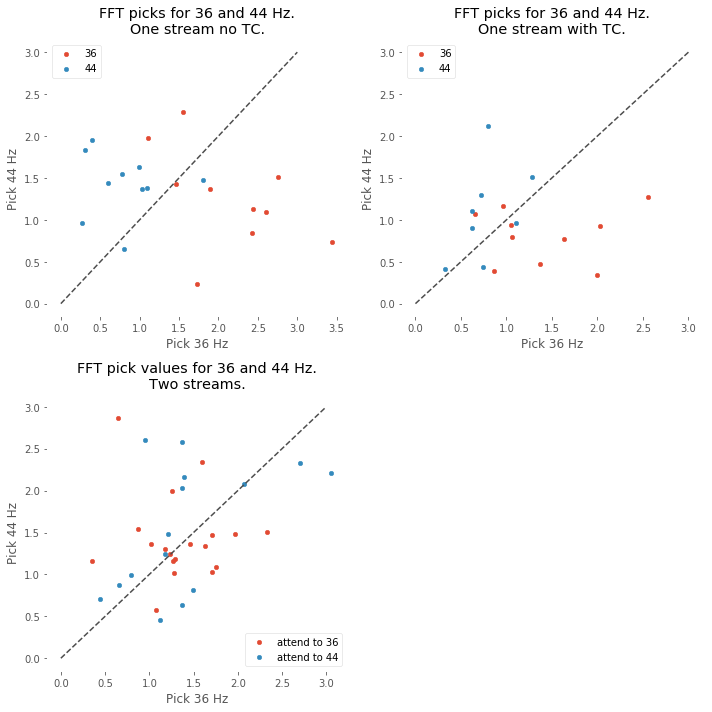

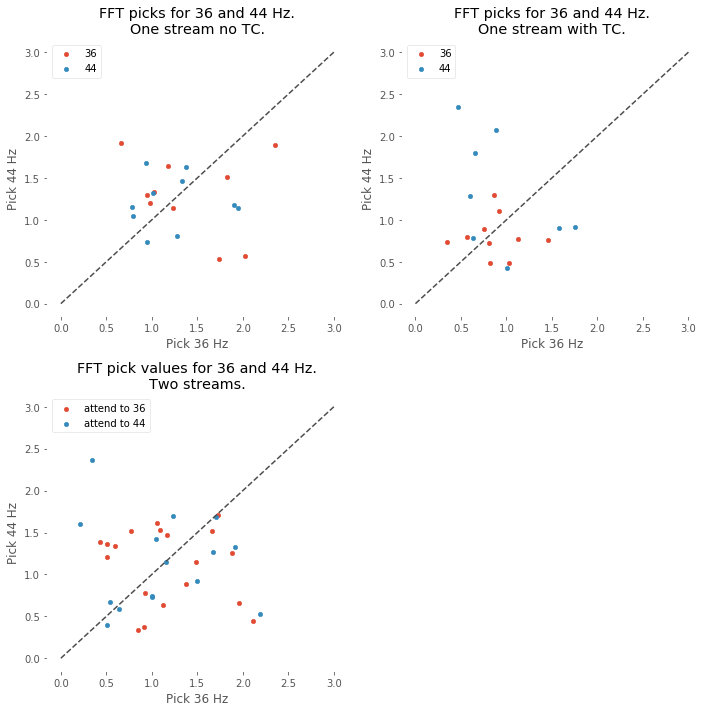

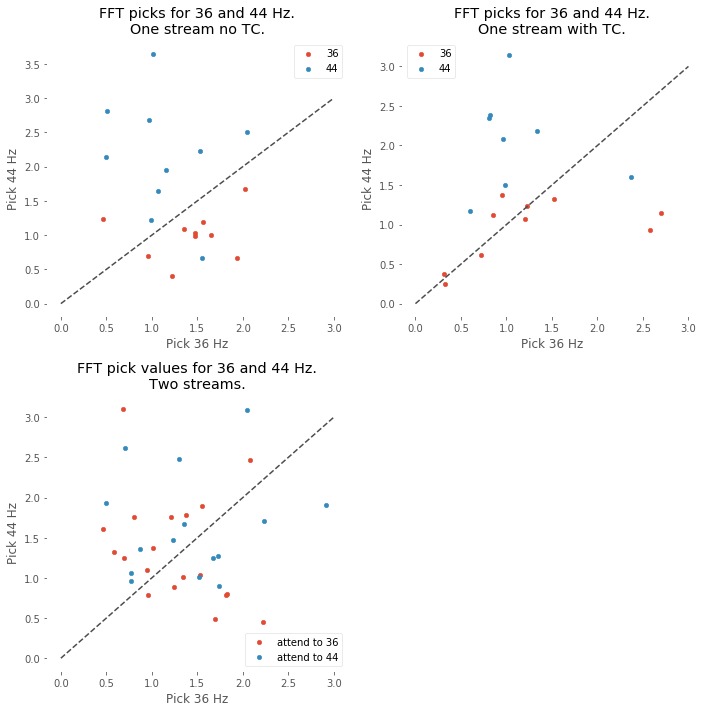

In [110]:
pylab.rcParams['figure.figsize'] = (10, 10)

for i in range(4):
    performances = analyses(subjs[i], verbose=False)
    subjBadTrials = performances.trial[performances.dprime<0.5].values
    print i, subjBadTrials
    subjSession1Good = np.setdiff1d(np.arange(10), allBadTrials.astype(int))
    subjSession2Good = np.setdiff1d(np.arange(10,20), allBadTrials.astype(int))
    subjSession3Good = np.setdiff1d(np.arange(20,30), allBadTrials.astype(int))
    subjSession4Good = np.setdiff1d(np.arange(30,40), allBadTrials.astype(int))
    subjSession5_6Good = np.setdiff1d(np.arange(40,60), allBadTrials.astype(int))
    subjSession7_8Good = np.setdiff1d(np.arange(60,80), allBadTrials.astype(int))
    
    
    plt.figure()
    plt.subplot(2, 2, 1)
    plt.plot([0, 3], [0, 3], ls="--", c=".3")
    plt.scatter(allPicks36[subjSession1Good, i],
                allPicks44[subjSession1Good, i], label='36', s=20, alpha=1)
    plt.scatter(allPicks36[subjSession3Good, i],
                allPicks44[subjSession3Good, i], label='44', s=20, alpha=1)
    # plt.xlim(-0.3, 0.3)
    # plt.ylim(-0.3, 0.3)
    plt.xlabel('Pick 36 Hz')
    plt.ylabel('Pick 44 Hz')
    plt.title("FFT picks for 36 and 44 Hz.\nOne stream no TC.")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot([0, 3], [0, 3], ls="--", c=".3")
    plt.scatter(allPicks36[subjSession2Good, i],
                allPicks44[subjSession2Good, i], label='36', s=20, alpha=1)
    plt.scatter(allPicks36[subjSession4Good, i],
                allPicks44[subjSession4Good, i], label='44', s=20, alpha=1)
    # plt.xlim(-0.3, 0.3)
    # plt.ylim(-0.3, 0.3)
    plt.xlabel('Pick 36 Hz')
    plt.ylabel('Pick 44 Hz')
    plt.title("FFT picks for 36 and 44 Hz.\nOne stream with TC.")
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot([0, 3], [0, 3], ls="--", c=".3")
    plt.scatter(allPicks36[subjSession5_6Good, i],
                allPicks44[subjSession5_6Good, i], label='attend to 36', s=20, alpha=1)
    plt.scatter(allPicks36[subjSession7_8Good, i],
                allPicks44[subjSession7_8Good, i], label='attend to 44', s=20, alpha=1)
    # plt.xlim(-0.3, 0.3)
    # plt.ylim(-0.3, 0.3)
    plt.xlabel('Pick 36 Hz')
    plt.ylabel('Pick 44 Hz')
    plt.title("FFT pick values for 36 and 44 Hz.\nTwo streams.")
    plt.legend()
    plt.tight_layout()


# SVM

A Suport Vector Machine algorithm has been used to categorize trials according to attention. One decoder has been build by participant and thus hyper-parameters optimization has been done separately for each decoder.

In [23]:
c_vals = [1, 5, 10, 20, 30, 50, 100, 200, 300, 500, 800, 1000,
                   2000, 3000, 5000, 6000, 10000, 30000]
durs = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
fs = 512.
electrodes = 64
dprimeThresh = 1
subjNum = 4
trialBehaviorAll = [trialBehavior_p1, trialBehavior_p2, trialBehavior_p3, trialBehavior_p4]

bestCOneStream = hyperOptC(eeg_aSSR_all, c_vals, durs, electrodes, dprimeThresh, subjNum,
                              condition='oneStream', fs=fs, trialBehaviorAll=trialBehaviorAll)
bestCTwoStreams = hyperOptC(eeg_aSSR_all, c_vals, durs, electrodes, dprimeThresh, subjNum,
                              condition='twoStreams', fs=fs, trialBehaviorAll=trialBehaviorAll)


In [68]:
pd.DataFrame(allDurPick36.T).to_csv('allDurPick36.csv')
pd.DataFrame(allDurPick44.T).to_csv('allDurPick44.csv')

In [58]:
durs = np.arange(1, 61)
allDurPick36 = np.zeros((len(durs), 320))
allDurPick44 = np.zeros((len(durs), 320))

for i in range(len(durs)):
    dur = durs[i]
    durSamples = int(np.round(fs*dur))

    pick36, pick44 = crossVal(eeg_aSSR_all[:, :durSamples, :64],
                              eeg_aSSR_all[:, :durSamples, :64],
                                      fs=512.)
    allDurPick36[i, :] = pick36
    allDurPick44[i, :] = pick44


In [26]:
p1AccAllOneStream, p2AccAllOneStream,\
    p3AccAllOneStream, p4AccAllOneStream = getBestAcc(durs, bestC=bestCOneStream)
p1AccAllTwoStreams, p2AccAllTwoStreams,\
    p3AccAllTwoStreams, p4AccAllTwoStreams = getBestAcc(durs, bestC=bestCTwoStreams)

[ 20   1   1 300]
[   1  300    5 2000]


We ended up with the following values of c:

For one stream condition:

- p1: 20
- p2: 1
- p3: 1
- p4: 300

For two streams condition:

- p1: 1
- p2: 300
- p3: 5
- p4: 2000

## Plot the accuracy

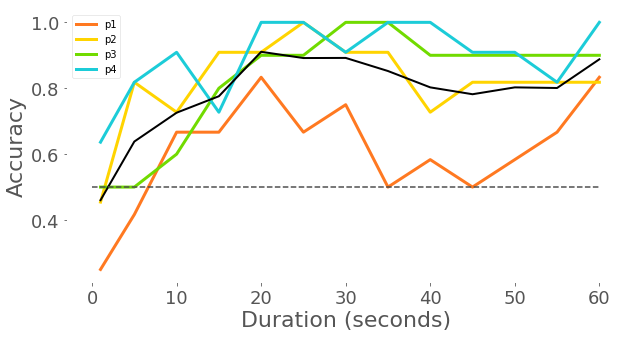

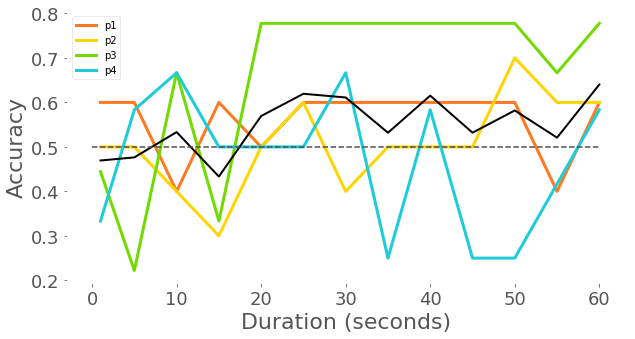

In [30]:
pylab.rcParams['figure.figsize'] = (10, 5)

flatui = ["#FF7921", "#FFD400", "#71DB00", "#1CCCD8"]
sns.set_palette(flatui)



accTCOneStream = plt.figure()
plt.plot(durs, p1AccAllOneStream, label='p1', linewidth=3)
plt.plot(durs, p2AccAllOneStream, label='p2', linewidth=3)
plt.plot(durs ,p3AccAllOneStream, label='p3', linewidth=3)
plt.plot(durs, p4AccAllOneStream, label='p4', linewidth=3)
# plot also the average across participants
plt.plot(durs, np.concatenate([p1AccAllOneStream,
                               p2AccAllOneStream,
                               p3AccAllOneStream,
                               p4AccAllOneStream]).reshape(subjNum, len(durs)).mean(axis=0),
        c='black', linewidth=2)
# Plot the chance level
plt.plot([0, 60], [0.5, 0.5], ls="--", c=".3")
plt.legend()
plt.xlabel('Duration (seconds)', fontsize=22)
plt.ylabel('Accuracy', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

accTCOneStream.savefig("images/accTCOneStream.pdf")



# Two streams
accTCTwoStreams = plt.figure()
plt.plot(durs, p1AccAllTwoStreams1, label='p1', linewidth=3)
plt.plot(durs, p2AccAllTwoStreams1, label='p2', linewidth=3)
plt.plot(durs ,p3AccAllTwoStreams1, label='p3', linewidth=3)
plt.plot(durs, p4AccAllTwoStreams1, label='p4', linewidth=3)
# plot also the average across participants
plt.plot(durs, np.concatenate([p1AccAllTwoStreams1,
                               p2AccAllTwoStreams1,
                               p3AccAllTwoStreams1,
                               p4AccAllTwoStreams1]).reshape(subjNum, len(durs)).mean(axis=0),
        c='black', linewidth=2)
# Plot the chance level
plt.plot([0, 60], [0.5, 0.5], ls="--", c=".3")
plt.legend()
plt.xlabel('Duration (seconds)', fontsize=22)
plt.ylabel('Accuracy', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

accTCTwoStreams.savefig("images/accTCTwoStreams.pdf")


In [577]:
pick36Filt = butterLpass(pick36, cutoff=10, fs=40, order=5)
pick44Filt = butterLpass(pick44, cutoff=10, fs=40, order=5)

# DSS

I was unable to filter data from all participants at the same time so I filtered each dataset separatly.

In [32]:
data36_p1 = createBiasedSignal(eegData=eeg_aSSR_p1,
                            freqs=[35.95, 35.99, 36.01, 36.05],
                            fs=512.)
data44_p1 = createBiasedSignal(eegData=eeg_aSSR_p1,
                            freqs=[43.95, 43.99, 44.01, 44.05],
                            fs=512.)

data36_p2 = createBiasedSignal(eegData=eeg_aSSR_p2,
                            freqs=[35.95, 35.99, 36.01, 36.05],
                            fs=512.)
data44_p2 = createBiasedSignal(eegData=eeg_aSSR_p2,
                            freqs=[43.95, 43.99, 44.01, 44.05],
                            fs=512.)

data36_p3 = createBiasedSignal(eegData=eeg_aSSR_p3,
                            freqs=[35.95, 35.99, 36.01, 36.05],
                            fs=512.)
data44_p3 = createBiasedSignal(eegData=eeg_aSSR_p3,
                            freqs=[43.95, 43.99, 44.01, 44.05],
                            fs=512.)

data36_p4 = createBiasedSignal(eegData=eeg_aSSR_p4,
                            freqs=[35.95, 35.99, 36.01, 36.05],
                            fs=512.)
data44_p4 = createBiasedSignal(eegData=eeg_aSSR_p4,
                            freqs=[43.95, 43.99, 44.01, 44.05],
                            fs=512.)


reshape...
filter...
Creating cheby filter of order 5...
Data contain multiple columns. Apply filter on each columns.
reshape...
reshape...
filter...
Creating cheby filter of order 5...
Data contain multiple columns. Apply filter on each columns.
reshape...


In [27]:
data36_p1p2 = np.concatenate([data36_p1, data36_p2])
del data36_p1, data36_p2
data36_p3p4 = np.concatenate([data36_p3, data36_p4])
del data36_p3, data36_p4
data36_all = np.concatenate([data36_p1p2, data36_p3p4])
del data36_p1p2, data36_p3p4

data44_p1p2 = np.concatenate([data44_p1, data44_p2])
del data44_p1, data44_p2
data44_p3p4 = np.concatenate([data44_p3, data44_p4])
del data44_p3, data44_p4
data44_all = np.concatenate([data44_p1p2, data44_p3p4])
del data44_p1p2, data44_p3p4

In [36]:
data36_p1 = data36_p1.reshape((80, 29696, 64))
data44_p1 = data44_p1.reshape((80, 29696, 64))

In [28]:
data36_all = data36_all.reshape((320, 29696, 64))
data44_all = data44_all.reshape((320, 29696, 64))

In [ ]:
# Create biased signal
data36 = createBiasedSignal(eegData=eeg_aSSR_all,
                            freqs=[35.95, 35.99, 36.01, 36.05],
                            fs=512.)
data44 = createBiasedSignal(eegData=eeg_aSSR_all,
                            freqs=[43.95, 43.99, 44.01, 44.05],
                            fs=512.)

reshape...
filter...
Creating cheby filter of order 5...
Data contain multiple columns. Apply filter on each columns.


In [ ]:
data44 = createBiasedSignal(eegData=eeg_aSSR_p4,
                            freqs=[43.95, 43.99, 44.01, 44.05],
                            fs=512.)

In [1267]:
data36Wide = createBiasedSignal(eegData=eeg_aSSR_p4,
                            freqs=[32, 32.5, 40, 40.5],
                            fs=512.)
data44Wide = createBiasedSignal(eegData=eeg_aSSR_p4,
                            freqs=[43.85, 43.95, 44.05, 44.1],
                            fs=512.)

Creating cheby filter of order 22...
Data contain multiple columns. Apply filter on each columns.


a (29696, 1)
0


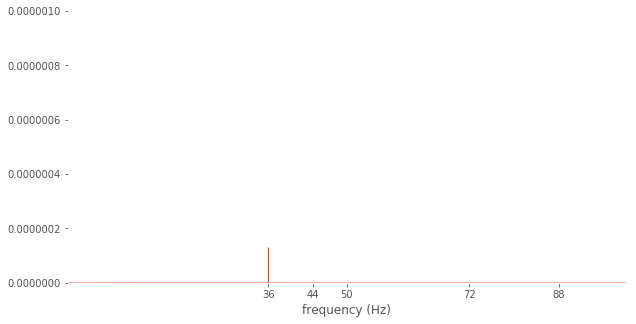

In [30]:
pylab.rcParams['figure.figsize'] = (10, 5)
# for i in range(64):
plot3DMatrix(data36_all,
         picks=np.array([0, 1, 2, 3, 4, 5, 6]),
         trialList=np.arange(40, 60),
         average=True,
         trialDur=60,
         offset=0,
         normalize=False,
         fs=512.,
         freqMin=0,
         freqMax=100,
         yMin=0,
         yMax=0.000001,
         xticks=[36, 44, 50, 72, 88],
         averageTimeDomain=True,
        averageElectrodes=True,
            returnFFT=False)

In [61]:
cov0 = covUnnorm(eeg_aSSR_all[trialsSession1, :, :])
cov36 = covUnnorm(data36_all[trialsSession1, :, :])
cov44 = covUnnorm(data44_all[trialsSession1, :, :])
DSS36 = computeDSS(cov0, cov36)
DSS44 = computeDSS(cov0, cov44)

In [63]:
dataDSS36 = applyDSS(eeg_aSSR_all, DSS36)
dataDSS44 = applyDSS(eeg_aSSR_all, DSS44)

KeyboardInterrupt: 

In [1451]:
def getPickTrials(data, freq, fs):
    aAll = []

    for trial in range(data.shape[0]):
        a = computePickEnergy(data[trial, :, :], pickFreq=freq, showPlot=False, fs=fs)
        aAll.append(a.mean())
    return aAll


allPicks36 = np.array(getPickTrials(dataDSS36[:, :, :1], freq=36, fs=512.))
allPicks44 = np.array(getPickTrials(dataDSS44[:, :, :1], freq=44, fs=512.))

a (20480, 1)
0


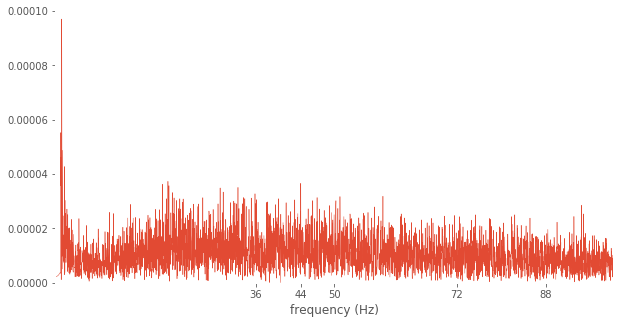

In [53]:
pylab.rcParams['figure.figsize'] = (10, 5)
plot3DMatrix(dataDSS44,
             picks=np.array([0]),
             trialList=np.arange(60, 80),
             average=False,
             trialDur=40,
             offset=0,
             normalize=False,
             fs=512.,
             freqMin=0,
             freqMax=100,
             yMin=0,
             yMax=0.0001,
             xticks=[36, 44, 50, 72, 88],
             averageTimeDomain=True,
            averageElectrodes=False,
            returnFFT=False)

In [241]:
allDSS = crossValidateDSS(eeg_aSSR_p2, eeg_aSSR_p1, data36, trials=np.arange(30))

24.417030809


a (29696, 1)
0


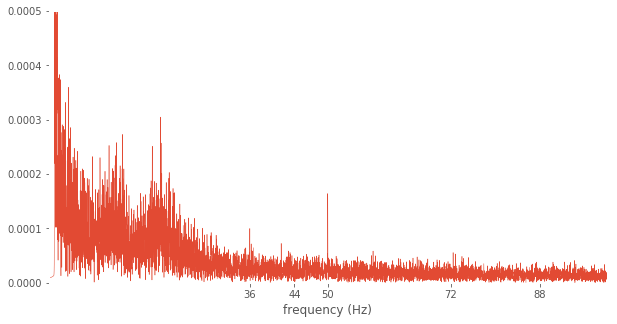

In [244]:
pylab.rcParams['figure.figsize'] = (10, 5)
plot3DMatrix(allDSS,
             picks=np.arange(1),
             trialList=np.array([2]),
             average=True,
             trialDur=60,
             offset=0,
             normalize=False,
             fs=512.,
             freqMin=0,
             freqMax=100,
             yMin=0,
             yMax=0.0005,
             xticks=[36, 44, 50, 72, 88],
             averageTimeDomain=True,
            averageElectrodes=False)